In [ ]:
# 1) Imports & paths
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
ACT_DIR = PROJECT_ROOT / "activations/Qwen_0.5B/model_layers_0_20250505_164739"
META_DIR = ACT_DIR       

# your loader: adjust if not numpy arrays
def load_and_pool(path):
    arr = np.load(path)
    if arr.ndim == 3 and arr.shape[0] == 1:
        arr = arr[0]          # from (1, seq_len, dim) → (seq_len, dim)
    return arr.mean(axis=0)  # → (hidden_dim,)


In [ ]:
features = []
meta = []
for npy in sorted(ACT_DIR.glob("activations_*.npy")):
    # Pool the activations
    arr = np.load(npy)
    if arr.ndim == 3 and arr.shape[0] == 1:
        arr = arr[0]
    feat = arr.mean(axis=0)
    features.append(feat)

    # load the json file
    idx = npy.stem.split("_")[1]           # '0', '1', etc.
    meta_path = ACT_DIR / f"meta_{idx}.json"
    info = json.loads(meta_path.read_text())
    info["file_name"]  = npy.name
    info["token_count"]= len(info.get("tokens", []))
    meta.append(info)

# 3) Stack into arrays / DataFrame
X_pool  = np.vstack(features)             # (n_samples, hidden_dim)
meta_df  = pd.DataFrame(meta)
print("Loaded:", X_pool.shape, "and", meta_df.shape)

Loaded: (21, 896) and (21, 4)


In [34]:
# 3) Bag‐of‐tokens via MultiLabelBinarizer
mlb = MultiLabelBinarizer(sparse_output=True)
X_tok = mlb.fit_transform(meta_df["tokens"])
# X_tok: sparse matrix (n_samples, n_unique_tokens)

# 4) Combine pooled features + token indicators
from scipy import sparse
X_full = sparse.hstack([X_pool, X_tok], format="csr")
print("Full feature matrix:", X_full.shape)  
# (n_samples, hidden_dim + n_unique_tokens)

# 5) PCA on the combined matrix
n_components = min(10, X_full.shape[0], X_full.shape[1])
pca = PCA(n_components=n_components)
pcs = pca.fit_transform(X_full.toarray())  # PCA needs dense input

# 6) Attach PC scores to metadata
for i in range(n_components):
    meta_df[f"PC{i+1}"] = pcs[:, i]

Full feature matrix: (21, 928)


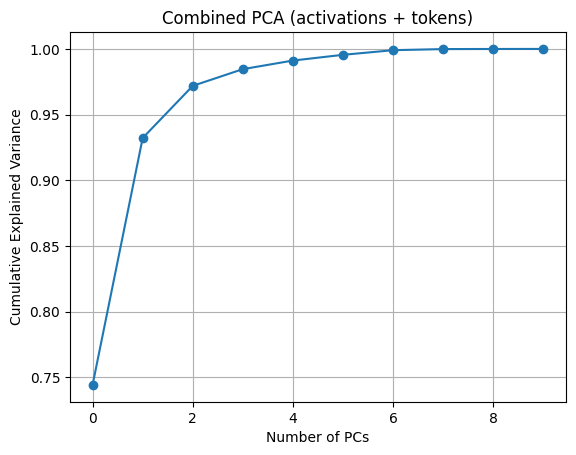

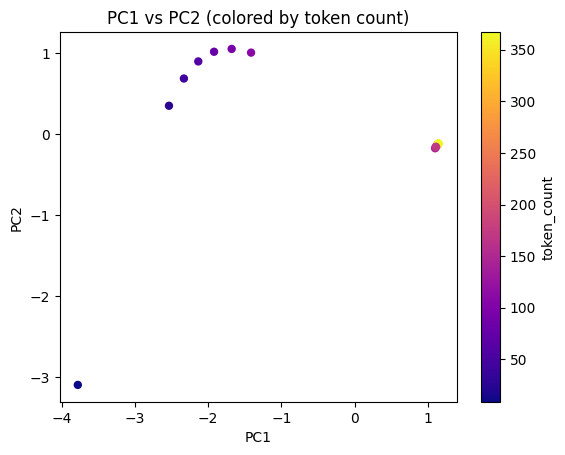

            file_name  token_count       PC1       PC2
0   activations_0.npy            9 -3.777835 -3.093534
1   activations_1.npy           26 -2.533583  0.350117
2  activations_10.npy          188  1.116485 -0.148901
3  activations_11.npy          205  1.120917 -0.143188
4  activations_12.npy          222  1.124644 -0.138611


In [35]:
# 7) Plot explained variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative Explained Variance")
plt.title("Combined PCA (activations + tokens)")
plt.grid(True)
plt.show()

# 8) Scatter PC1 vs PC2 colored by token_count
plt.figure()
sc = plt.scatter(meta_df["PC1"], meta_df["PC2"],
                 c=meta_df["token_count"], cmap="plasma", s=25)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PC1 vs PC2 (colored by token count)")
plt.colorbar(sc, label="token_count")
plt.show()

# 9) Inspect results
print(meta_df[["file_name", "token_count", "PC1", "PC2"]].head())